In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np
%load_ext rpy2.ipython

In [2]:
# Load all the data
dir = "/Users/gustxsr/Documents/Stanford/PoldrackLab/Vagus Nerve and Cognition/eyeNARPS/NARPS_MG_asc_processed"
saccade_data = []

for file in os.listdir(dir):
    if file.endswith("saccade_info.csv"):
        csv = pd.read_csv(os.path.join(dir, file))
        csv['sub'] = int(file[4:7])
        saccade_data.append(csv)

saccade_data = pd.concat(saccade_data)

saccade_data['rate'] = saccade_data['num_sacc'] / saccade_data['duration'] *1000

In [3]:
behav = pd.read_csv("/Users/gustxsr/Documents/Stanford/PoldrackLab/github/analysisNARPS/data/narps_behav_data.csv")
trial_id = [i for i in range(1, 257)]*behav['sub'].nunique()
behav['trial'] = trial_id
behav['uncertain'] = behav['response_int'].apply(lambda x: 1 if x == 2 or x == 3 else 0)
behav = behav.loc[:, ~behav.columns.str.contains('^Unnamed')]

# Create column called dist_indiff
behav['dist_indiff'] = np.abs(behav['gain'] - behav['loss']) / np.sqrt(2)

In [6]:
min(behav.query('trial == 1 | trial == 65 | trial == 129 | trial == 193')['RT'])

0.728

In [17]:
# merge
saccade_data = saccade_data.merge(behav, on=['sub', 'trial'])

In [23]:
saccade_data

,trial,num_sacc,duration,mean_ampl,sub,rate,run,condition,gain,loss,RT,accept,response_int,participant_response,uncertain,dist_indiff
0,129,19,6082,1.920000,47,3.123972,3,equalIndifference,32,18,1.543,1,3.0,weakly_accept,1,9.899495
1,130,17,5200,2.245882,47,3.269231,3,equalIndifference,14,17,1.855,0,2.0,weakly_reject,1,2.121320
2,131,12,5500,1.663333,47,2.181818,3,equalIndifference,40,13,1.855,1,4.0,strongly_accept,0,19.091883
3,132,19,6900,2.189474,47,2.753623,3,equalIndifference,36,13,2.985,1,4.0,strongly_accept,0,16.263456
4,133,15,5700,2.464667,47,2.631579,3,equalIndifference,34,10,2.061,1,4.0,strongly_accept,0,16.970563
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14075,124,15,7401,1.602000,115,2.026753,2,equalIndifference,16,8,3.197,1,3.0,weakly_accept,1,5.656854
14076,125,12,7400,2.788333,115,1.621622,2,equalIndifference,40,7,1.854,1,4.0,strongly_accept,0,23.334524
14077,126,10,5001,1.109000,115,1.999600,2,equalIndifference,18,10,1.648,1,3.0,weakly_accept,1,5.656854
14078,127,12,7701,1.395833,115,1.558239,2,equalIndifference,12,6,1.646,1,3.0,weakly_accept,1,4.242641


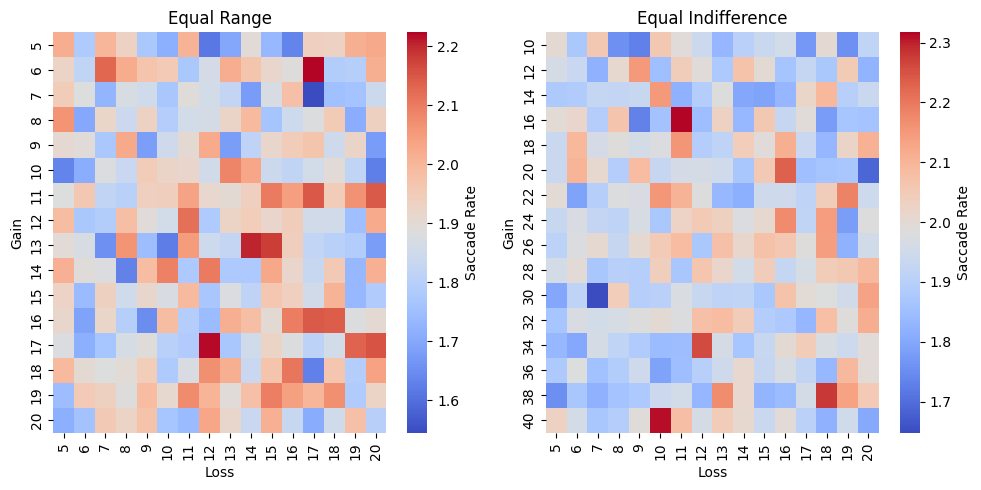

In [18]:
# Two figures: Sacc rate per condition
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
hmap_data = saccade_data.query("condition == 'equalRange'").groupby(['gain', 'loss'])['rate'].mean().unstack()
sns.heatmap(hmap_data, cmap='coolwarm', cbar_kws={'label': 'Saccade Rate'}, ax = axs[0])
axs[0].set_title("Equal Range")
axs[0].set_xlabel("Loss")
axs[0].set_ylabel("Gain")

hmap_data = saccade_data.query("condition == 'equalIndifference'").groupby(['gain', 'loss'])['rate'].mean().unstack()
sns.heatmap(hmap_data, cmap='coolwarm', cbar_kws={'label': 'Saccade Rate'}, ax = axs[1])
axs[1].set_title("Equal Indifference")
axs[1].set_xlabel("Loss")
axs[1].set_ylabel("Gain")
plt.tight_layout()
plt.show()

In [32]:
%%R -i saccade_data
library(lme4)
library(lmerTest)

saccade_data$response_int = as.factor(saccade_data$response_int)
m = lmer(rate ~ RT *condition + response_int*condition + (1|sub), data = saccade_data)

In [33]:
%%R

# plot residuals
par(mfrow=c(2,2))
plot(m)

summary(m)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [


lmerModLmerTest]
Formula: rate ~ RT * condition + response_int * condition + (1 | sub)
   Data: saccade_data

REML criterion at convergence: 22903.9

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.7739 -0.6059 -0.0192  0.5759  7.9877 

Random effects:
 Groups   Name        Variance Std.Dev.
 sub      (Intercept) 0.2442   0.4941  
 Residual             0.2906   0.5391  
Number of obs: 14080, groups:  sub, 55

Fixed effects:
                                      Estimate Std. Error         df t value
(Intercept)                          1.727e+00  9.692e-02  6.090e+01  17.821
RT                                   1.165e-01  1.302e-02  1.405e+04   8.949
conditionequalRange                  3.504e-02  1.379e-01  6.024e+01   0.254
response_int2                        1.639e-02  2.408e-02  1.402e+04   0.681
response_int3                        2.897e-02  2.178e-02  1.402e+04   1.330
response_int4                        5.032e-02  1.902e-02  1.403e+04   2.646
response_intNaN  

In [ ]:
# If spend more time answering, then more look! DUH
# okay so saccades are worthless... still and interesting concept. 